# CARDIOCULATOR

In [1]:
# pip install --upgrade dask-cudf

Cardiovascular diseases define a group of diseases that affect the heart and blood vessels. This group includes various types of diseases such as heart attack, stroke, heart failure, and arrhythmia. Cardiovascular diseases are among the most common causes of death worldwide and generally emerge due to lifestyle factors (smoking, alcohol, insufficient physical activity, etc.) and genetic predispositions.

According to the World Health Organization's data from 2019, **ischemic heart disease** stands at the forefront of the top 10 diseases causing death today and is held responsible for approximately 16% of deaths. Such a high rate being attributed to a single disease is quite a tragic situation. However, since many risk factors for cardiovascular diseases are preventable, it is essential for individuals and societies to be informed and proactive in reducing these risks.

In this context, a machine learning model that can predict disease risk with cardiovascular medical data could be a significant step for public health. This model can assist individuals in better understanding their health conditions and taking necessary precautions.

**ABOUT DATASET**

The columns and their descriptions of our dataset, which consists of 70,000 observation units, are as follows:

* *id*      -> Unique identifier for each person
* *age*     -> Age (day)   
* *gender*  -> Gender       
* *height*  -> Height (cm)     
* *weight*  -> Weight (kg)    
* *ap_hi*   -> Systolic blood pressure (mm Hg)     
* *ap_lo*   -> Diastolic blood pressure (mm Hg)
* *cholesterol*  -> Cholesterol level in the blood (total)
* *gluc*    -> Blood glucose level        
* *smoke*   -> Smoking status       
* *alco*    -> Alcohol consumption status      
* *active*  -> Physical activity   
* *cardio*  -> Presence/Absence of cardiovascular disease -> **Target**

<a id='section_1'></a>
### Data Introduction and Exploration

We will start with the necessary library imports and adjustments.

In [2]:
import numpy as np 
import pandas as pd
import joblib
from termcolor import colored
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

#----------------------------------------------#

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, classification_report, RocCurveDisplay

#----------------------------------------------#

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 300)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_real = pd.read_csv("/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv", sep=';')

To protect the original data, provide a fallback in case of errors, and assess the impact of changes, we will create a copy of the dataframe and work on that copy.

In [4]:
df = df_real.copy()

First, let's take a look at the dataframe.

In [5]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.000,100,60,1,1,0,0,0,0


In [6]:
TARGET = "cardio"
# Our target variable is "cardio"

When we look at the dataset, the first thing we notice is that the data in the age variable is based on days. Therefore, we will make corrections first.

In [7]:
df["age"] = df["age"].map(lambda x: x // 365)

In [8]:
df["age"].head(10)

0    50
1    55
2    51
3    48
4    47
5    60
6    60
7    61
8    48
9    54
Name: age, dtype: int64

In the gender column, the values are currently set to 1 and 2, but to optimize computations for the machine learning model, we will convert them to 0 and 1. To understand which category represents which gender, let's examine the dataset based on gender.

In [9]:
df.groupby("gender").mean()

,id,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
gender,,,,,,,,,,,,
1,49898.345,52.954,161.356,72.566,128.139,94.523,1.385,1.235,0.018,0.025,0.802,0.497
2,50110.247,52.629,169.948,77.257,130.079,100.552,1.334,1.210,0.219,0.106,0.807,0.505


As seen, the age averages are equal; in this case, we can say that the category with higher averages in height and weight represents males.

In [10]:
df['gender'] = df['gender'].replace({2: "male", 1: "female"})

In [11]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,male,168,62.000,110,80,1,1,0,0,1,0
1,1,55,female,156,85.000,140,90,3,1,0,0,1,1
2,2,51,female,165,64.000,130,70,3,1,0,0,0,1
3,3,48,male,169,82.000,150,100,1,1,0,0,1,1
4,4,47,female,156,56.000,100,60,1,1,0,0,0,0


In [12]:
def check_df(dataframe):
    print("---------- SHAPE ----------")
    print(dataframe.shape)
    print("---------- TYPES ----------")
    print(dataframe.dtypes)
    print("---------- NA VALUES ----------")
    print(dataframe.isnull().sum())

In [13]:
check_df(df)

---------- SHAPE ----------
(70000, 13)
---------- TYPES ----------
id               int64
age              int64
gender          object
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object
---------- NA VALUES ----------
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [14]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

#### About function :

 * It gives the names of categorical, numerical, and categorical but cardinal variables in the data set.

Note: Categorical variables with numerical appearance are also included in categorical variables.
 
 Parameters :
 
 ***cat_th*** (int) : Optional threshold value for variables that appear numeric but are categorical
 
 ***car_th*** (int) : Optional threshold value for categorical but cardinal variables
 
Note : cat_cols + num_cols + cat_but_car = total number of variables

Note : num_but_cat is inside cat_cols


In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f"\n{colored('Numerical Columns:','blue', attrs=['reverse'])} {num_cols}\n\n\n{colored('Categorical Columns:','magenta', attrs=['reverse'])} {cat_cols}\n\n\n"
        f"{colored('Cardinal Columns:','cyan', attrs=['reverse'])}{cat_but_car}\n")

Observations: 70000
Variables: 13
cat_cols: 7
num_cols: 6
cat_but_car: 0
num_but_cat: 6

Numerical Columns: ['id', 'age', 'height', 'weight', 'ap_hi', 'ap_lo']


Categorical Columns: ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


Cardinal Columns:[]



In [16]:
# For analysis of categorical variables :

def cat_summary(dataframe, col_name, plot=False):
    display(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [17]:

for col in cat_cols:
    cat_summary(df, col)

,gender,Ratio
gender,,
female,45530,65.043
male,24470,34.957


,cholesterol,Ratio
cholesterol,,
1,52385,74.836
2,9549,13.641
3,8066,11.523


,gluc,Ratio
gluc,,
1,59479,84.970
3,5331,7.616
2,5190,7.414


,smoke,Ratio
smoke,,
0,63831,91.187
1,6169,8.813


,alco,Ratio
alco,,
0,66236,94.623
1,3764,5.377


,active,Ratio
active,,
1,56261,80.373
0,13739,19.627


,cardio,Ratio
cardio,,
0,35021,50.030
1,34979,49.970


* Based on our observations, we can infer that there is an imbalance in the variables related to 'smoking', 'alcohol', and 'activity' in the dataset. Therefore, the values in these variables may not be very reliable for this study.

* One point to note is that the values in the glucose and cholesterol variables in the dataset are categorized as 1, 2, and 3. Based on our domain knowledge, we can say that 1 represents normal values, 2 represents values slightly outside the normal range, and 3 represents values that are considered abnormal.


#### Result----------        A1C Test----------       Fasting Blood Sugar Test

  **Diabetes**-------> 6.5% or above---------    126 mg/dL or above ----- **category 3**
  
  **Prediabetes**---->  5.7% – 6.4%-----------      100 – 125 mg/dL-------- **category 2**
  
  **Normal**--------->       Below 5.7%------------      99 mg/dL or below----- **category 1**
  
  
#### Result ............     Fasting Blood Sugar Test

  **Low** ...........................     <200 mg/dl ------- **category 3**
  
  **Borderline High** .....  200-239 mg/dl --- **category 2**
  
  **High** ............................  >240 mg/dl ------ **category 1**
  
 * In our dataset, it's quite advantageous that the distribution of our target variable is homogeneous. However, we can say that the distribution of the gender variable is not as balanced.

In [18]:
df['gender'] = df['gender'].replace({'male': 0, 'female': 1})

In [19]:
# For analysis of numerical variables :

def num_summary(dataframe, numerical_col, plot=False):
    if plot:
        dataframe[numerical_col].hist(bins=200)        
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

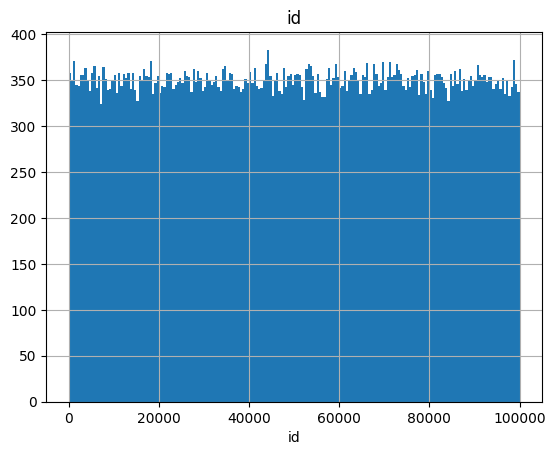

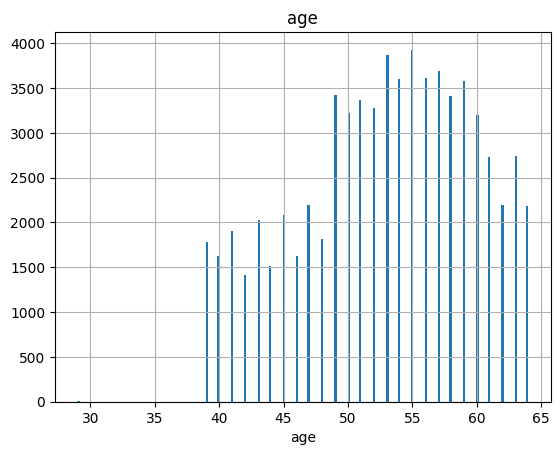

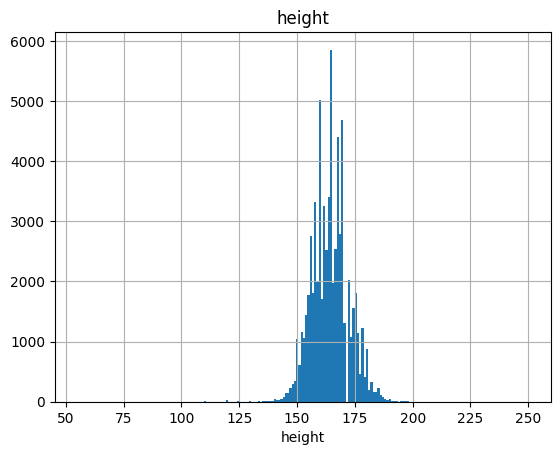

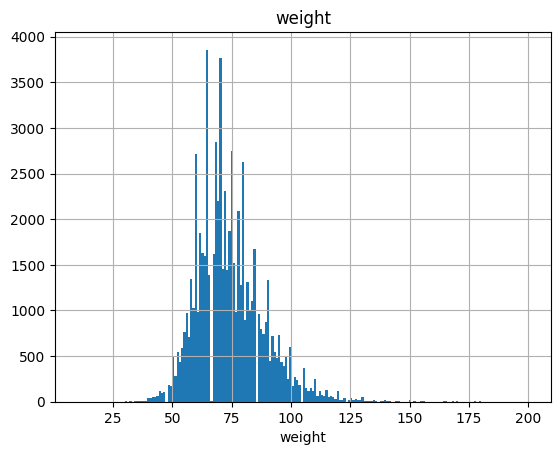

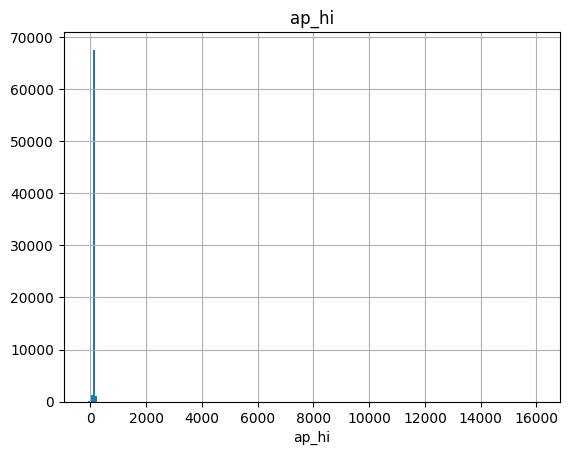

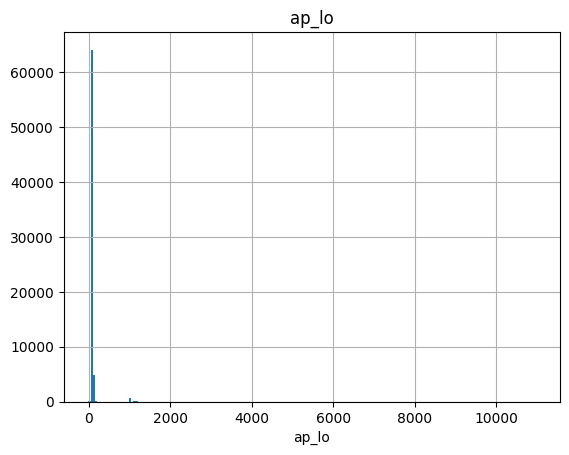

In [20]:
for col in num_cols:
    num_summary(df, col, True)

In [21]:
# Analysis of Categorical Variables on the Target Variable:

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_Mean": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [22]:
for col in cat_cols:
    target_summary_with_cat(df,TARGET,col)

        TARGET_Mean
gender             
0             0.505
1             0.497


             TARGET_Mean
cholesterol             
1                  0.440
2                  0.602
3                  0.765


      TARGET_Mean
gluc             
1           0.481
2           0.593
3           0.622


       TARGET_Mean
smoke             
0            0.502
1            0.475


      TARGET_Mean
alco             
0           0.501
1           0.484


        TARGET_Mean
active             
0             0.536
1             0.491


        TARGET_Mean
cardio             
0             0.000
1             1.000




In [23]:
# Analysis of Numerical Variables on the Target Variable:

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [24]:
for col in num_cols:
    target_summary_with_num(df, TARGET, col)

              id
cardio          
0      49862.869
1      50082.102


          age
cardio       
0      51.231
1      54.452


        height
cardio        
0      164.448
1      164.270


        weight
cardio        
0       71.592
1       76.822


         ap_hi
cardio        
0      120.433
1      137.212


         ap_lo
cardio        
0       84.252
1      109.024




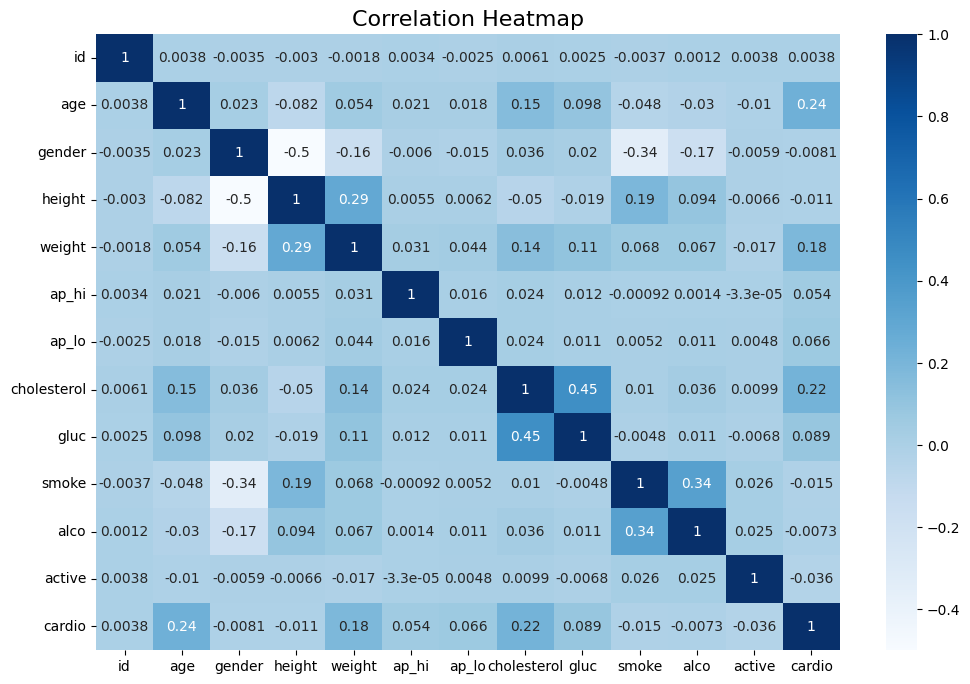

In [25]:
cor = df.corr()
plt.figure(figsize=(12, 8))
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True) 
sns.heatmap(cor, cmap="Blues", annot=True)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()

<a id='section_2'></a>
### Exploratory Data Analysis(EDA) with Pandas-Profiling

In [26]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.84 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible

In [27]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.000,49972.420,28851.302,0.000,25006.750,50001.500,74889.250,99999.000
age,70000.000,52.841,6.767,29.000,48.000,53.000,58.000,64.000
gender,70000.000,0.650,0.477,0.000,0.000,1.000,1.000,1.000
height,70000.000,164.359,8.210,55.000,159.000,165.000,170.000,250.000
weight,70000.000,74.206,14.396,10.000,65.000,72.000,82.000,200.000
ap_hi,70000.000,128.817,154.011,-150.000,120.000,120.000,140.000,16020.000
ap_lo,70000.000,96.630,188.473,-70.000,80.000,80.000,90.000,11000.000
cholesterol,70000.000,1.367,0.680,1.000,1.000,1.000,2.000,3.000
gluc,70000.000,1.226,0.572,1.000,1.000,1.000,1.000,3.000
smoke,70000.000,0.088,0.283,0.000,0.000,0.000,0.000,1.000


Based on the statistical information above, we can say that there are some imbalances and outliers in the dataset. From this point on, medical domain knowledge will be used to make adjustments to the values in the dataset.

<a id='section_3'></a>
### Feature Engineering for Outliers

In [29]:
df[df["ap_hi"]<0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4607,6525,41,1,165,78.000,-100,80,2,1,0,0,1,0
16021,22881,60,0,161,90.000,-115,70,1,1,0,0,1,0
20536,29313,42,1,153,54.000,-100,70,1,1,0,0,1,0
23988,34295,50,1,162,74.000,-140,90,1,1,0,0,1,1
25240,36025,40,0,168,50.000,-120,80,2,1,0,0,0,1
35040,50055,63,0,168,59.000,-150,80,1,1,0,0,1,1
46627,66571,64,0,160,59.000,-120,80,1,1,0,0,0,0


Blood pressure values can never be negative. When we look at the values, we see that they are numerically correct, but due to the negative signs in front of them, they become outliers; therefore, these values will be converted to positive.

In [30]:
df["ap_hi"]=df["ap_hi"].abs()

In [31]:
df[df["ap_lo"]<0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,85816,61,1,167,74.000,15,-70,1,1,0,0,1,1


In [32]:
df["ap_lo"]=df["ap_lo"].abs()

In [33]:
df[df["ap_hi"]<25].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
567,815,58,1,168,78.000,14,90,2,1,0,0,1,1
927,1294,59,0,175,70.000,14,90,3,1,0,0,1,1
979,1360,49,1,172,65.000,11,80,1,3,0,0,1,0
1600,2260,52,1,165,66.000,12,80,1,1,0,0,1,0
1627,2301,61,1,165,71.000,14,80,1,1,0,0,1,1


Blood pressure values are expressed in mm Hg during medical evaluations, so they are typically represented as 120/80 rather than 12/8. Considering this, I have observed that systolic blood pressure values in the dataset can be found as less than 25 when they are actually below 250 mm Hg. Hence, I've decided to standardize these values.

In [34]:
df['ap_hi'] = df['ap_hi'].apply(lambda x: x*10 if x < 25 else x)

In [35]:
df[df["ap_hi"]<25].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
8757,12494,46,0,163,63.000,10,2088,1,1,1,0,1,0
42334,60477,51,1,171,80.000,10,1088,1,1,0,0,1,1


After correcting the values and checking again, we find that in 2 observation units, the systolic blood pressure value remains at 10 mm Hg. At this point, I believe it's more appropriate to remove these observation units.

In [36]:
df.drop(df[df["ap_hi"]<25].index, inplace = True)

In [37]:
df[df["ap_lo"]<15].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2014,2845,62,0,167,59.000,906,0,1,1,0,0,1,0
6737,9610,45,1,156,61.000,150,10,1,1,0,0,0,1
7598,10843,40,0,70,72.000,120,8,1,1,0,0,1,0
9777,13943,59,1,166,125.000,120,8,3,1,0,0,1,1
10106,14410,50,1,152,50.000,150,10,3,1,0,0,1,1


We will perform the same procedures for the diastolic blood pressure as well.

In [38]:
df['ap_lo'] = df['ap_lo'].apply(lambda x: x*10 if x < 15 else x)

In [39]:
df[df["ap_lo"]<15]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2014,2845,62,0,167,59.000,906,0,1,1,0,0,1,0
13489,19258,41,0,150,60.000,130,0,1,1,0,0,0,0
16459,23512,56,1,156,50.000,138,0,3,1,0,0,1,1
17381,24837,49,1,164,78.000,138,0,1,1,0,0,1,0
22923,32749,58,0,166,68.000,149,0,1,1,0,0,1,1
23867,34120,44,1,161,92.000,906,0,2,1,0,0,1,1
25454,36325,49,0,176,73.000,120,0,1,1,0,0,1,0
27686,39577,64,0,180,73.000,140,0,1,1,1,1,1,1
31783,45400,44,1,170,64.000,907,0,1,1,0,0,1,0
35140,50210,57,1,146,55.000,130,10,1,1,0,0,0,0


We will also delete the observations with a diastolic blood pressure value of 0.

In [40]:
df.drop(df[df["ap_lo"]<15].index, inplace = True)

Now, for these two blood pressure values, I will set a lower and upper threshold based on my domain knowledge. I will delete the observations that have values below and above these thresholds. For systolic blood pressure, these values will be 80 and 250, and for diastolic blood pressure, these values will be 50 and 150. The adjustments according to this are as follows.

In [41]:
df.drop(df[df["ap_lo"]<50].index, inplace = True)

In [42]:
df.drop(df[df['ap_lo'] > 150].index, inplace = True)

In [43]:
df.drop(df[df['ap_hi'] > 250].index, inplace = True)

In [44]:
df.drop(df[df['ap_hi'] < 80].index, inplace = True)

Technically, systolic blood pressure should always be higher than diastolic blood pressure; any records indicating otherwise in the dataset are likely errors, for these observation units, a conversion will be made between systolic and diastolic blood pressure values.

In [45]:
df[df["ap_hi"]<df["ap_lo"]].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,681,52,1,156,65.000,120,150,2,1,0,0,1,0
2384,3356,64,1,154,102.000,90,150,1,1,0,0,0,1
2990,4214,60,0,182,90.000,80,140,3,3,0,0,1,1
3447,4880,54,0,180,80.000,80,125,3,3,1,1,1,1
3623,5130,59,1,160,83.000,80,120,1,1,0,0,1,0


In [46]:
condition = df["ap_hi"]<df["ap_lo"]
df.loc[condition, ["ap_hi", "ap_lo"]] = df.loc[condition, ["ap_lo", "ap_hi"]].values

After this stage, we will examine the values in other variables and make changes. For now, it seems our adjustments related to blood pressure values are complete.

In [47]:
df[df["ap_hi"]==df["ap_lo"]].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
12785,18238,43,0,178,105.000,100,100,1,1,0,0,0,1
32190,45975,63,1,162,120.000,100,100,1,1,0,0,1,0


In [48]:
df.drop(df[df["ap_hi"]==df["ap_lo"]].index, inplace = True)

In [49]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,68910.000,49971.191,28848.921,0.000,25000.500,50007.500,74869.750,99999.000
age,68910.000,52.827,6.769,29.000,48.000,53.000,58.000,64.000
gender,68910.000,0.651,0.477,0.000,0.000,1.000,1.000,1.000
height,68910.000,164.361,8.204,55.000,159.000,165.000,170.000,250.000
weight,68910.000,74.119,14.328,11.000,65.000,72.000,82.000,200.000
ap_hi,68910.000,126.674,16.674,80.000,120.000,120.000,140.000,240.000
ap_lo,68910.000,81.319,9.400,50.000,80.000,80.000,90.000,150.000
cholesterol,68910.000,1.364,0.679,1.000,1.000,1.000,1.000,3.000
gluc,68910.000,1.226,0.572,1.000,1.000,1.000,1.000,3.000
smoke,68910.000,0.088,0.283,0.000,0.000,0.000,0.000,1.000


In [50]:
df[df["height"]<140].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,309,59,0,76,55.000,120,80,1,1,0,0,1,0
2412,3399,61,0,138,52.000,140,100,1,1,0,0,1,1
2944,4150,53,1,134,52.000,120,70,1,1,0,0,0,0
3208,4523,50,1,136,57.000,120,80,1,1,0,0,1,0
3420,4838,39,1,100,70.000,100,70,1,1,0,0,1,0


In [51]:
df.drop(df[df['height'] < 140].index, inplace = True)

In [52]:
df[df["weight"]<35].head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
14722,21040,62,1,143,34.000,100,70,1,1,0,0,1,0
16906,24167,47,0,170,31.000,150,90,2,2,0,0,1,1
18559,26503,49,1,160,30.000,120,80,1,1,0,0,1,1
22016,31439,42,1,146,32.000,100,70,1,1,0,0,0,0
26806,38312,63,1,157,23.000,110,80,1,1,0,0,1,0


In [53]:
df.drop(df[df['weight'] < 35].index, inplace = True)

In [54]:
df.drop(df[df['weight'] > 150].index, inplace = True)

In [55]:
df.drop(df[df['height'] >210].index, inplace = True)

In [56]:
#Let's convert the "weight" variable to an integer type.
df["weight"]=df["weight"].astype(int)

In [57]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,68698.000,49972.678,28848.922,0.000,25009.250,50012.500,74867.750,99999.000
age,68698.000,52.829,6.767,29.000,48.000,53.000,58.000,64.000
gender,68698.000,0.651,0.477,0.000,0.000,1.000,1.000,1.000
height,68698.000,164.464,7.798,140.000,159.000,165.000,170.000,207.000
weight,68698.000,74.064,14.069,35.000,65.000,72.000,82.000,150.000
ap_hi,68698.000,126.672,16.663,80.000,120.000,120.000,140.000,240.000
ap_lo,68698.000,81.319,9.392,50.000,80.000,80.000,90.000,150.000
cholesterol,68698.000,1.365,0.679,1.000,1.000,1.000,1.000,3.000
gluc,68698.000,1.226,0.572,1.000,1.000,1.000,1.000,3.000
smoke,68698.000,0.088,0.283,0.000,0.000,0.000,0.000,1.000


When we take a rough look at the min-max, standard deviation values, and averages, we can say that the values we have are currently balanced.

At this point, using the parameters we have, we will generate features for body mass index, body mass index classification, blood pressure value classification, and pulse pressure.

<a id='section_4'></a>
### Feature Extraction

In [58]:
df["bmi"] = df["weight"] *10000 / ((df["height"])**2)

In [59]:
conditions = [
    (df["bmi"] <= 15),                            # 0 - Anorexic
    (df["bmi"] > 15) & (df["bmi"] <= 18.5),       # 1 - Underweight
    (df["bmi"] > 18.5) & (df["bmi"] <= 25),       # 2 - Normal weight
    (df["bmi"] > 25) & (df["bmi"] <= 30),         # 3 - Overweight
    (df["bmi"] > 30) & (df["bmi"] <= 35),         # 4 - Obesity Class I
    (df["bmi"] > 35) & (df["bmi"] <= 40),         # 5 - Obesity Class II
    (df["bmi"] > 40)                              # 6 - Obesity Class III 
]

bmi_class = [0, 1, 2, 3, 4, 5, 6]

df["bmi_class"] = np.select(conditions, bmi_class)

In [60]:
def categorize_blood_pressure(dataframe):
    systolic = dataframe['ap_hi']
    diastolic = dataframe['ap_lo']

    if systolic < 120 and diastolic < 80:
        return 0
    elif systolic < 130 and diastolic < 85:
        return 1
    elif (systolic >= 130 and systolic <= 139) or (diastolic >= 85 and diastolic <= 89):
        return 2
    elif (systolic >= 140 and systolic <= 159) or (diastolic >= 90 and diastolic <= 99):
        return 3
    elif (systolic >= 160 and systolic <= 179) or (diastolic >= 100 and diastolic <= 109):
        return 4
    elif systolic >= 180 or diastolic >= 110:
        return 5
    elif systolic >= 140 and systolic <= 160 and diastolic < 90:
        return 6
    elif systolic > 160 and diastolic < 90:
        return 7
    else:
        return -1  #This section is for observations that don't meet any conditions - perhaps for error checking or review.

df['bp_cat'] = df.apply(categorize_blood_pressure, axis=1)

In [61]:
df["pulse_press"] = df["ap_hi"] - df["ap_lo"]

In [62]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmi_class,bp_cat,pulse_press
0,0,50,0,168,62,110,80,1,1,0,0,1,0,21.967,2,1,30
1,1,55,1,156,85,140,90,3,1,0,0,1,1,34.928,4,3,50
2,2,51,1,165,64,130,70,3,1,0,0,0,1,23.508,2,2,60
3,3,48,0,169,82,150,100,1,1,0,0,1,1,28.710,3,3,50
4,4,47,1,156,56,100,60,1,1,0,0,0,0,23.011,2,0,40


In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,68698.000,49972.678,28848.922,0.000,25009.250,50012.500,74867.750,99999.000
age,68698.000,52.829,6.767,29.000,48.000,53.000,58.000,64.000
gender,68698.000,0.651,0.477,0.000,0.000,1.000,1.000,1.000
height,68698.000,164.464,7.798,140.000,159.000,165.000,170.000,207.000
weight,68698.000,74.064,14.069,35.000,65.000,72.000,82.000,150.000
ap_hi,68698.000,126.672,16.663,80.000,120.000,120.000,140.000,240.000
ap_lo,68698.000,81.319,9.392,50.000,80.000,80.000,90.000,150.000
cholesterol,68698.000,1.365,0.679,1.000,1.000,1.000,1.000,3.000
gluc,68698.000,1.226,0.572,1.000,1.000,1.000,1.000,3.000
smoke,68698.000,0.088,0.283,0.000,0.000,0.000,0.000,1.000


It is essential to perform data analysis and adjustments for the features we have generated based on our domain knowledge.

In [64]:
df.drop(df[df['bmi'] < 16].index, inplace = True)

In [65]:
df.drop(df[df['bmi'] > 45].index, inplace = True)

In [66]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,68215.000,49979.590,28851.529,0.000,25012.500,50022.000,74880.500,99999.000
age,68215.000,52.823,6.769,29.000,48.000,53.000,58.000,64.000
gender,68215.000,0.650,0.477,0.000,0.000,1.000,1.000,1.000
height,68215.000,164.499,7.784,140.000,159.000,165.000,170.000,207.000
weight,68215.000,73.772,13.515,36.000,65.000,72.000,82.000,149.000
ap_hi,68215.000,126.594,16.598,80.000,120.000,120.000,140.000,240.000
ap_lo,68215.000,81.282,9.361,50.000,80.000,80.000,90.000,150.000
cholesterol,68215.000,1.362,0.677,1.000,1.000,1.000,1.000,3.000
gluc,68215.000,1.224,0.570,1.000,1.000,1.000,1.000,3.000
smoke,68215.000,0.088,0.284,0.000,0.000,0.000,0.000,1.000


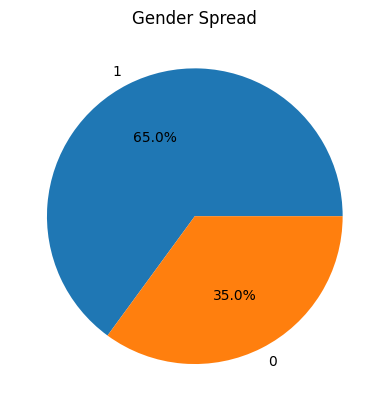

In [67]:

gender_spread = df['gender'].value_counts()
gender_spread.plot.pie(autopct='%1.1f%%')
plt.title("Gender Spread")
plt.ylabel('')
plt.show()

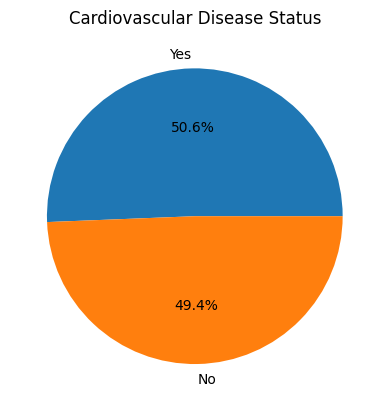

In [68]:
disease_status = df['cardio'].value_counts()
disease_status.plot.pie(autopct='%1.1f%%', labels=['Yes', 'No'])
plt.title("Cardiovascular Disease Status")
plt.ylabel('')
plt.show()

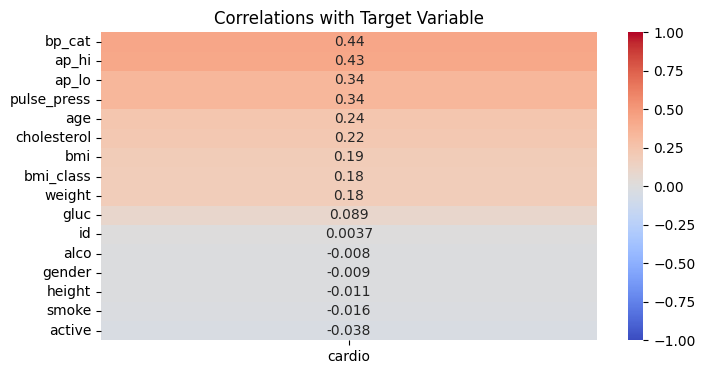

In [69]:
correlation_matrix = df.corr()

#We only take the correlations with 'target'.
target_correlation = correlation_matrix[TARGET].sort_values(ascending=False)
target_correlation = target_correlation.drop("cardio")

plt.figure(figsize=(8, 4))
sns.heatmap(target_correlation.to_frame(), cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.title("Correlations with Target Variable")
plt.show()

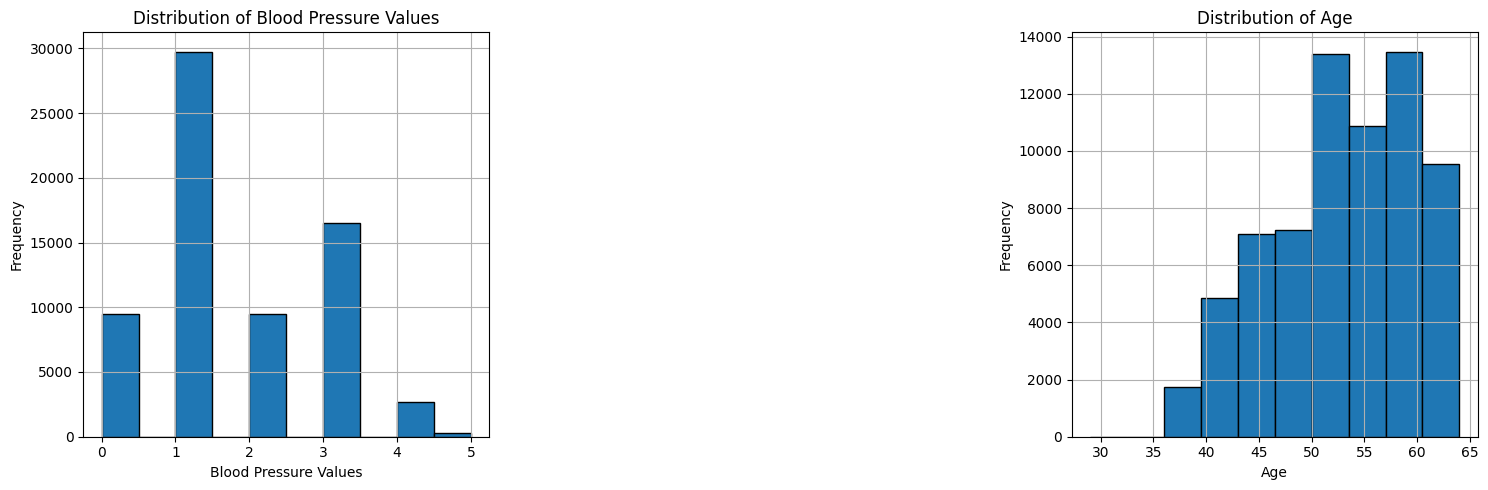

In [70]:
# Creating figure for histogram
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1) #In a 1-row x 3-column space, the first plot.
df['bp_cat'].hist(edgecolor='black')
plt.title('Distribution of Blood Pressure Values')
plt.xlabel('Blood Pressure Values')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3) 
df['age'].hist(edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()

<a id='section_5'></a>
### Machine Learning Model

In [71]:
y = df[TARGET]
X = df.drop(columns=['id', TARGET], axis = 1)

In [80]:
!pip install pycaret

In [77]:
# pip install --upgrade pandas

In [ ]:
pip install --upgrade dask-cudf

In [ ]:
# Assuming df is your dataframe
df.to_csv('/kaggle/working/my_data.csv', index=False)

In [81]:
# Accessing output file
import pandas as pd

# Load the data
df = pd.read_csv('/kaggle/working/my_data.csv')

In [ ]:
from pycaret.classification import *
s = setup(df, target = 'cardio', train_size = 0.8, ignore_features = 'id', fold = 3)

In [ ]:
best = compare_models()

* As seen above, with pycaret, we've seen which model objects might be successful for this project. Despite very minor differences in success rates, LightGBM works much faster, so we will use light gbm here.

In [ ]:
!pip install lightgbm

In [ ]:
lgbm_model = LGBMClassifier()

In [ ]:
lgbm_model.get_params()

In [ ]:
lgbm_model_= cross_validate(lgbm_model, X, y, cv = 10, scoring = ["accuracy", "f1", "roc_auc"])

In [ ]:
lgbm_model_["test_accuracy"].mean()

In [ ]:
lgbm_model_["test_f1"].mean()

In [ ]:
lgbm_model_["test_roc_auc"].mean()

     As can be seen, the success metrics of the base model established with LightGBM can be said to be quite good. Now, to achieve a slight increase in model performance, we will perform hyperparameter optimization.

<a id='section_6'></a>
### Hyperparameter Optimization with Grid Search CV

In [ ]:
params = {'colsample_bytree': [0.55,0.65,0.70,1],
         'min_child_samples':[12,15,20],
         'max_depth':[-1,3,7],
         'learning_rate':[0.1,0.5,1]}

In [ ]:
lgbm_best = GridSearchCV(lgbm_model,
                             params,
                             cv = 5,
                             n_jobs = -1,
                             verbose = True).fit(X, y)

In [ ]:
lgbm_best.best_score_

In [ ]:
lgbm_best.best_params_

<a id='section_7'></a>
### Final Model

In [ ]:
final_model = lgbm_model.set_params(**lgbm_best.best_params_).fit(X, y)

In [ ]:
cv_results_last = cross_validate(final_model, 
                           X,
                           y,
                           cv = 5,
                           scoring = ["accuracy", "f1", "roc_auc"])

In [ ]:
cv_results_last['test_accuracy'].mean()

In [ ]:
cv_results_last['test_f1'].mean()

In [ ]:
cv_results_last['test_roc_auc'].mean()

In [ ]:
accuracy = cv_results_last['test_accuracy'].mean()
f1_score = cv_results_last['test_f1'].mean()
roc_auc = cv_results_last['test_roc_auc'].mean()


data = {
    'Metric': ['Accuracy', 'F1', 'ROC AUC'],
    'Value': [accuracy, f1_score, roc_auc]
}
dfii = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Metric', y='Value', data=dfii, palette="viridis")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.ylim(0, 1.1)

If we want to observe which variable the model learned more from during training:

In [ ]:
import lightgbm as lgb
lgb.plot_importance(final_model, importance_type='split', max_num_features=6, figsize=(10, 6))
plt.title("Features Used to Train Model.")
plt.show()

 Let's randomly select an observation unit from our dataset and have our model make a prediction.

In [ ]:
random_user = X.sample(1)
final_model.predict(random_user)

Our prediction model is ready. If we want to use our model on different computers after this stage, we can save our model as a file using joblib.
#### Thanks to machine learning, we have gained a different perspective on preventive medicine in the medical sector. If you have any questions, comments, or feedback, please feel free to share and **do not forget to take care your heart and yourself**

<center><img src="https://media.giphy.com/media/j2xsmlsdig4PWE7GgA/giphy.gif" width="500"/></center>

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your dataset and split it into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define your base models
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model2 = BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=10, random_state=42)
model3 = XGBClassifier(random_state=42)
model4 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[('rf', model1), ('bagging', model2), ('xgb', model3), ('mlp', model4)],
    final_estimator=LogisticRegression(),  # You can choose another final estimator based on your needs
    stack_method='auto',
)

# Fit the stacking ensemble on your training data
stacking_ensemble.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_ensemble.predict(X_test)

# Evaluate the accuracy of the stacking ensemble
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the stacking ensemble: {accuracy}")